In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lifelines.utils import concordance_index
from metric import score
import torch
from torch import nn

In [2]:
train_path = "data/train.csv"
test_path = "data/test.csv"
sample_path = "data/sample_submission.csv"
data_dict_path = "data/data_dictionary.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
data_dict_df = pd.read_csv(data_dict_path)

In [3]:
RMV = ["ID", "efs", "efs_time", "y"]
FEATURES = [c for c in train_df.columns if not c in RMV]
print(f"Total features: {len(FEATURES)} - {FEATURES}")

Total features: 57 - ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [4]:
CAT_FEATURES = []
for f in FEATURES:
    if train_df[f].dtype == "object":
        CAT_FEATURES.append(f)
        train_df[f] = train_df[f].fillna("NAN")
        test_df[f] = test_df[f].fillna("NAN")

print(f"Categorical features: {len(CAT_FEATURES)} - {CAT_FEATURES}")

Categorical features: 35 - ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [6]:
combined = pd.concat([train_df,test_df],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CAT_FEATURES:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train_df)].copy()
test = combined.iloc[len(train_df):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

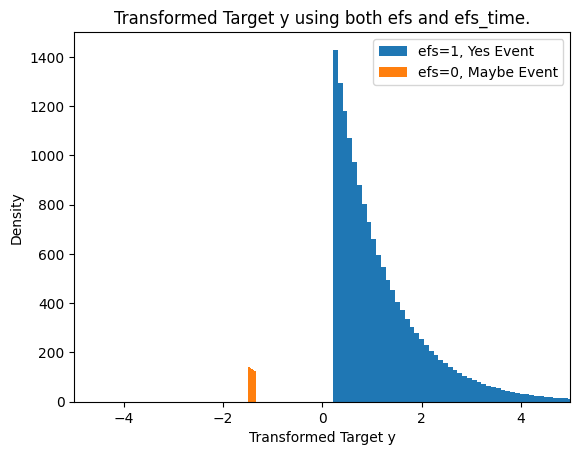

In [7]:
train["y"] = train.efs_time.values
mx = train.loc[train.efs==1,"efs_time"].max()
mn = train.loc[train.efs==0,"efs_time"].min()
train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
train.y = train.y.rank()
train.loc[train.efs==0,"y"] += 2*len(train)
train.y = train.y / train.y.max()
train.y = np.log( train.y )
train.y -= train.y.mean()
train.y *= -1.0

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlim((-5,5))
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.relu(self.out(x))



In [5]:
tensor_x = torch.tensor(X.to_numpy(), dtype=torch.float32)
tensor_y = torch.tensor(y.to_numpy(), dtype=torch.float32)

train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [6]:
model = NeuralNetwork(input_dim=tensor_x.shape[1])

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [7]:
def train(model, train_loader, optimizer, num_epochs=10):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        total_loss = 0
        epoch_loss = 0
        
        for data, label in train_loader:
            pred = model(data)
            loss = criterion(pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return loss_history

In [8]:
loss_history = train(model, train_loader, optimizer)

C:\Users\tkvkh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 0.0486
Epoch [2/10], Loss: 0.0366
Epoch [3/10], Loss: 0.0316
Epoch [4/10], Loss: 0.0329
Epoch [5/10], Loss: 0.0545
Epoch [6/10], Loss: 0.0356
Epoch [7/10], Loss: 0.0338
Epoch [8/10], Loss: 0.0305
Epoch [9/10], Loss: 0.0368
Epoch [10/10], Loss: 0.0345


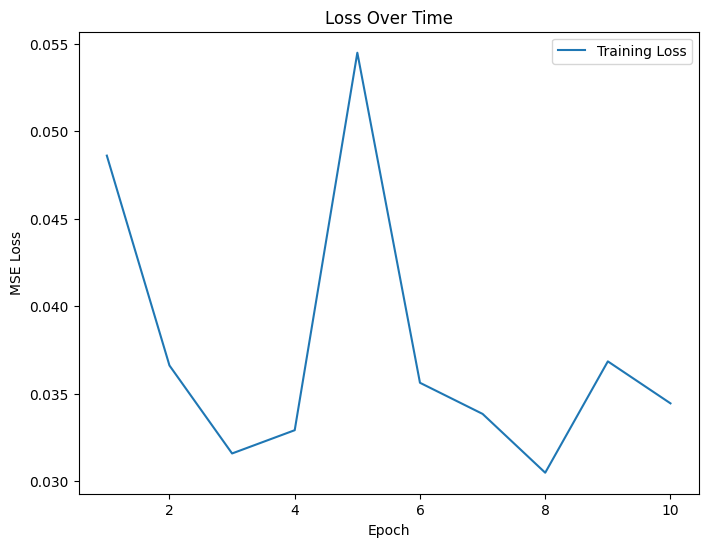

In [9]:
# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10+1), loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Time')
plt.legend()
plt.show()

In [10]:
model.eval()
risk_score = model(tensor_x)
risk_score = risk_score.detach().numpy()
efs = np.array(train_df["efs"])
efs_time = np.array(train_df["efs_time"])
concordance_index(efs, risk_score, efs_time)

0.4706778398934589

In [11]:
X = train_df.drop(columns=["y"])
y = train_df["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

efs = np.array(X_test["efs"])
efs_time = np.array(X_test["efs_time"])
race_group = np.array(X_test["race_group"])
id = np.array(X_test["ID"])

test_x = X_test.drop(columns=["ID", "efs", "efs_time"])
test_x = test_x.to_numpy()
test_x = torch.tensor(test_x, dtype=torch.float32)

y_pred = model(test_x).detach().numpy()
concordance_index(efs, y_pred, efs_time)

0.4788803733130675

In [12]:
pred_df = X_test[["ID", "race_group", "efs", "efs_time"]]
submission = pd.DataFrame(data={
    "ID": X_test["ID"],
    "prediction": y_pred.flatten()
})
m_score = score(pred_df, submission, "ID")
m_score

0.5002181640817694